# PINN-SGM Demo: Solving Fokker-Planck for Merton Model

This notebook demonstrates the workflow for:
1. Solving the Fokker-Planck equation for the Merton model using a PINN
2. Extracting theoretical score functions

**Author**: Bilal Saleh Husain  

# Part 1: Setup & Configuration

Configure the mathematical model, PDE equation, neural network architecture, and training parameters.

## 1.1 Setup and Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.insert(0, os.path.abspath('../src'))

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Import PINN-SGM components
from pinn_sgm.equations import FokkerPlanckMerton
from pinn_sgm.solvers import PINNSolver
from pinn_sgm.nets import DensityMLP
from pinn_sgm.config import MertonModelConfig, PINNConfig, TrainingConfig, ScoreModelConfig
from pinn_sgm.utils import ScoreExtractor, hybrid_score
from pinn_sgm.utils import plot_density_evolution, plot_score_field, plot_training_history
from pinn_sgm.utils import plot_error_analysis

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1.2 Configure Merton Model

The Merton structural model assumes firm asset value $V_t$ follows:
$$dV_t = \mu V_t dt + \sigma V_t dW_t$$

In log-space $X_t = \ln V_t$:
$$dX_t = \alpha dt + \sigma dW_t, \quad \alpha = \mu - \frac{\sigma^2}{2}$$

In [2]:
# Configure Merton model parameters
merton_config = MertonModelConfig(
    mu=0.05,       # 5% expected asset return
    sigma=0.2,     # 20% asset volatility
    x0=0.0,        # Initial log-asset value (V_0 = exp(0) = 1)
)

print(f"Merton Model Configuration:")
print(f"  Asset drift (μ): {merton_config.mu}")
print(f"  Asset volatility (σ): {merton_config.sigma}")
print(f"  Effective drift (α): {merton_config.alpha:.6f}")
print(f"  Initial log-value (X_0): {merton_config.x0}")

Merton Model Configuration:
  Asset drift (μ): 0.05
  Asset volatility (σ): 0.2
  Effective drift (α): 0.030000
  Initial log-value (X_0): 0.0


## 1.3 Create Fokker-Planck Equation

The density $p(x, t)$ satisfies:
$$\frac{\partial p}{\partial t} + \alpha \frac{\partial p}{\partial x} - \frac{\sigma^2}{2} \frac{\partial^2 p}{\partial x^2} = 0$$

**Analytical Solution** (Gaussian):
$$p(x, t) = \frac{1}{\sqrt{2\pi \sigma^2 t}} \exp\left(-\frac{(x - x_0 - \alpha t)^2}{2\sigma^2 t}\right)$$

In [3]:
# Create Fokker-Planck equation
equation = FokkerPlanckMerton(
    config=merton_config,
    device=device
)

print(f"\nFokker-Planck Equation: {equation}")


Fokker-Planck Equation: FokkerPlanckMerton(μ=0.0500, σ=0.2000, α=0.0300, x0=0.0000)


## 1.4 Configure PINN Solver

The PINN minimizes:
$$\mathcal{L}(\theta) = \mathcal{L}_{\text{PDE}}(\theta) + \mathcal{L}_{\text{IC}}(\theta) + \mathcal{L}_{\text{norm}}(\theta)$$

In [29]:
# PINN configuration
pinn_config = PINNConfig(
    T=1.0,                     # Terminal time
    x_min=-5.0,                # Spatial domain
    x_max=5.0,
    num_collocation=10000,     # Interior points for PDE
    num_initial=5000,          # Points for initial condition
    num_boundary=0,            # No boundary conditions (unbounded domain)
    device=str(device),
    enforce_normalization=True,
    normalization_weight=1.0
)

# Training configuration with adaptive learning rate
training_config = TrainingConfig(
    batch_size=1000,
    epochs=10000,
    learning_rate=1e-3,
    lr_scheduler='step',  
    optimizer='adam',
    gradient_clip_val=1.0,
    verbose=True,
    log_interval=500
)

print(f"PINN Configuration:")
print(f"  Spatial domain: [{pinn_config.x_min}, {pinn_config.x_max}]")
print(f"  Time horizon: [0, {pinn_config.T}]")
print(f"  Collocation points: {pinn_config.num_collocation}")
print(f"\nTraining Configuration:")
print(f"  Epochs: {training_config.epochs}")
print(f"  Learning rate: {training_config.learning_rate}")
print(f"  LR scheduler: {training_config.lr_scheduler} (patience={training_config.lr_patience})")
print(f"  Batch size: {training_config.batch_size}")

PINN Configuration:
  Spatial domain: [-5.0, 5.0]
  Time horizon: [0, 1.0]
  Collocation points: 10000

Training Configuration:
  Epochs: 10000
  Learning rate: 0.001
  LR scheduler: step (patience=500)
  Batch size: 1000


## 1.5 Create Neural Network

We use a `DensityMLP` with Softplus output activation to ensure $p(x, t) > 0$:
$$p(x, t) = \text{Softplus}(\mathcal{N}_\theta(x, t)) = \log(1 + e^{z})$$

In [30]:
# Create neural network
network = DensityMLP(
    spatial_dim=1,    
    hidden_dims=[64, 64, 64], # 3 hidden layers with 64 neurons each
    activation='tanh',        # Tanh activation for hidden layers
    use_softplus=True         # Softplus output for positivity
)

print(f"\nNeural Network Architecture:")
print(network)
print(f"\nTotal parameters: {sum(p.numel() for p in network.parameters()):,}")


Neural Network Architecture:
DensityMLP(2 → 64 → 64 → 64 → 1, activation=tanh, output=Softplus, spatial_dim=1)

Total parameters: 8,577


# Part 2: Training

Train the PINN to solve the Fokker-Planck equation and analyze convergence.

## 2.1 Train PINN Solver

This cell trains the PINN by minimizing the physics residual and initial condition error.

In [31]:
# Create PINN solver
solver = PINNSolver(
    equation=equation,
    network=network,
    pinn_config=pinn_config,
    training_config=training_config
)

# Train the PINN
print("\nStarting PINN training...")
results = solver.train()


Starting PINN training...

Epoch        Loss         PDE          IC           BC           Time        
------------------------------------------------------------------------
0/10000      4.8430e+01   2.3825e-02   3.0972e+00   0.0000e+00   20.41it/s   
500/10000    3.2654e+00   2.8035e-02   3.2288e+00   0.0000e+00   39.47it/s   
1000/10000   2.4765e+00   1.0605e-01   2.2501e+00   0.0000e+00   40.15it/s   
1500/10000   7.6379e-01   4.0298e-02   6.7389e-01   0.0000e+00   38.50it/s   
2000/10000   1.0714e+00   1.0000e-01   8.8884e-01   0.0000e+00   38.06it/s   
2500/10000   2.1929e+00   1.0962e+00   1.0829e+00   0.0000e+00   37.21it/s   
3000/10000   1.0650e+00   7.3112e-02   9.5437e-01   0.0000e+00   36.88it/s   
3500/10000   3.3827e+00   2.6363e+00   7.2448e-01   0.0000e+00   36.35it/s   
4000/10000   5.6528e-01   5.0261e-02   5.1025e-01   0.0000e+00   34.98it/s   
4500/10000   1.0228e+00   8.3294e-02   9.2514e-01   0.0000e+00   34.42it/s   
5000/10000   3.1974e+00   2.6233e+00   5.

## 2.2 Visualize Training History

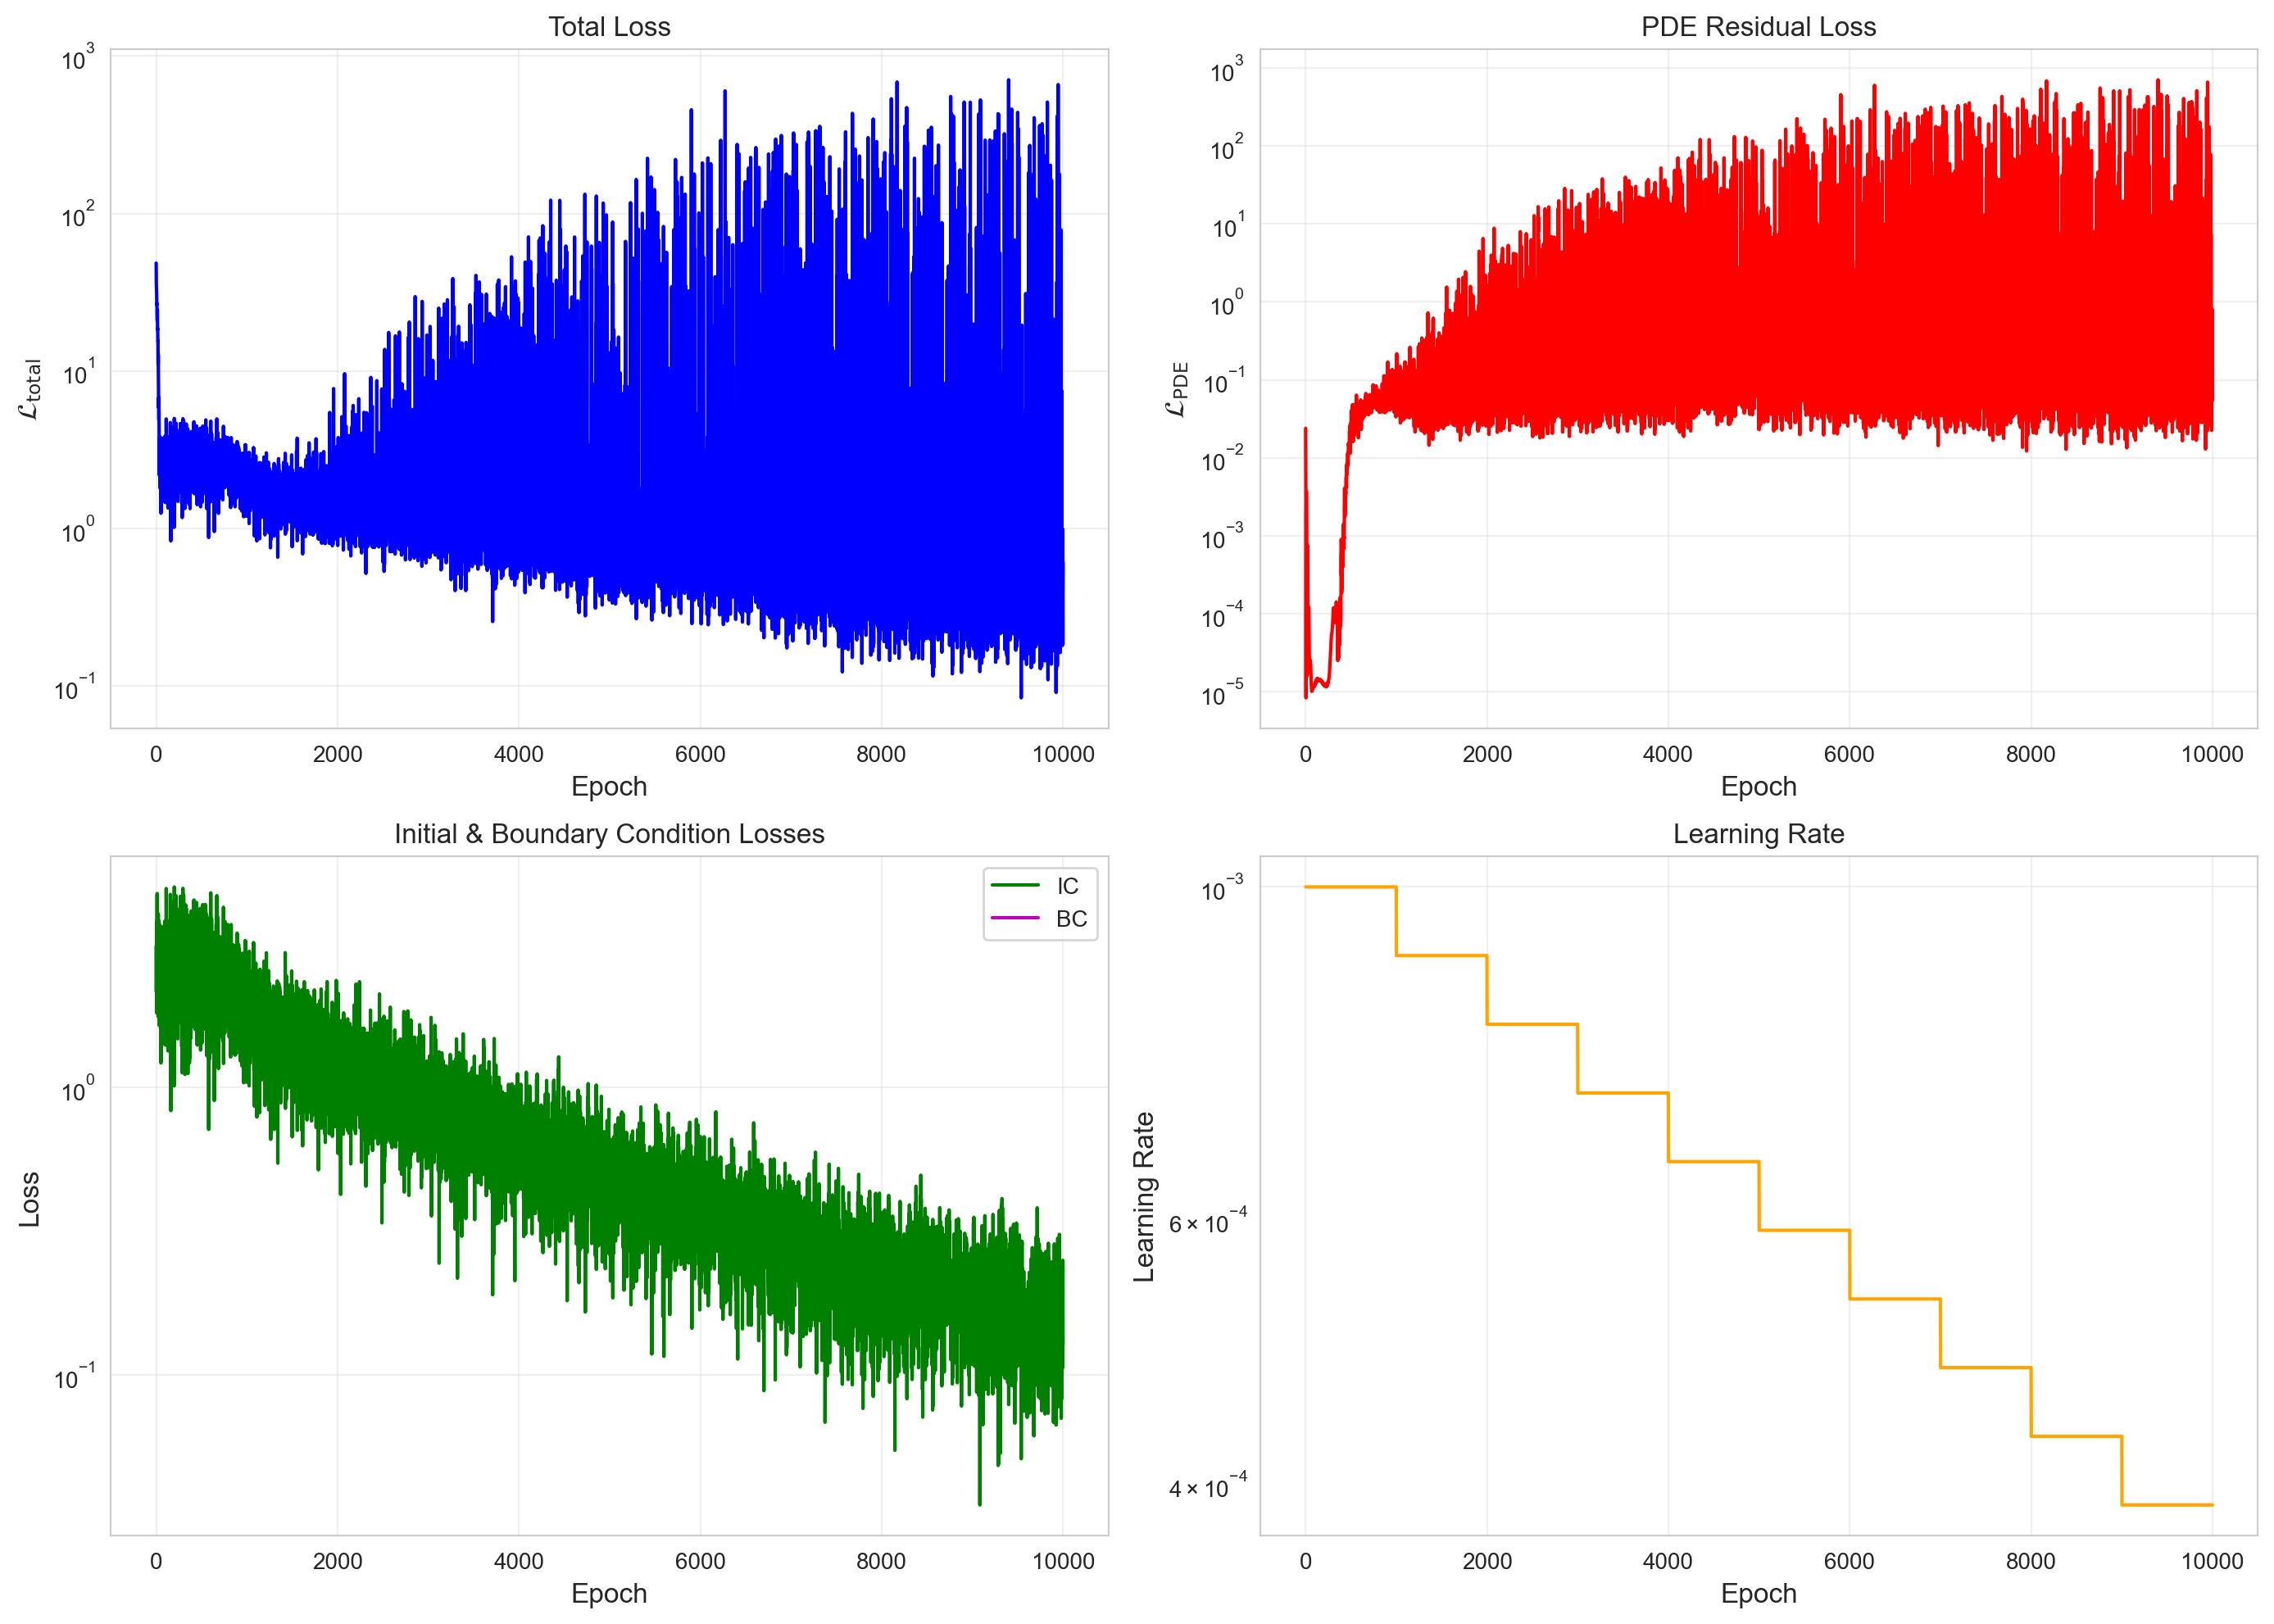

In [37]:
# Plot training history
fig = plot_training_history(solver.history)
plt.show()

# Part 3: Density Field Results

Visualize the learned probability density and compare with analytical solution.

## 3.1 Visualize Density Evolution

Compare PINN solution with analytical Gaussian solution.

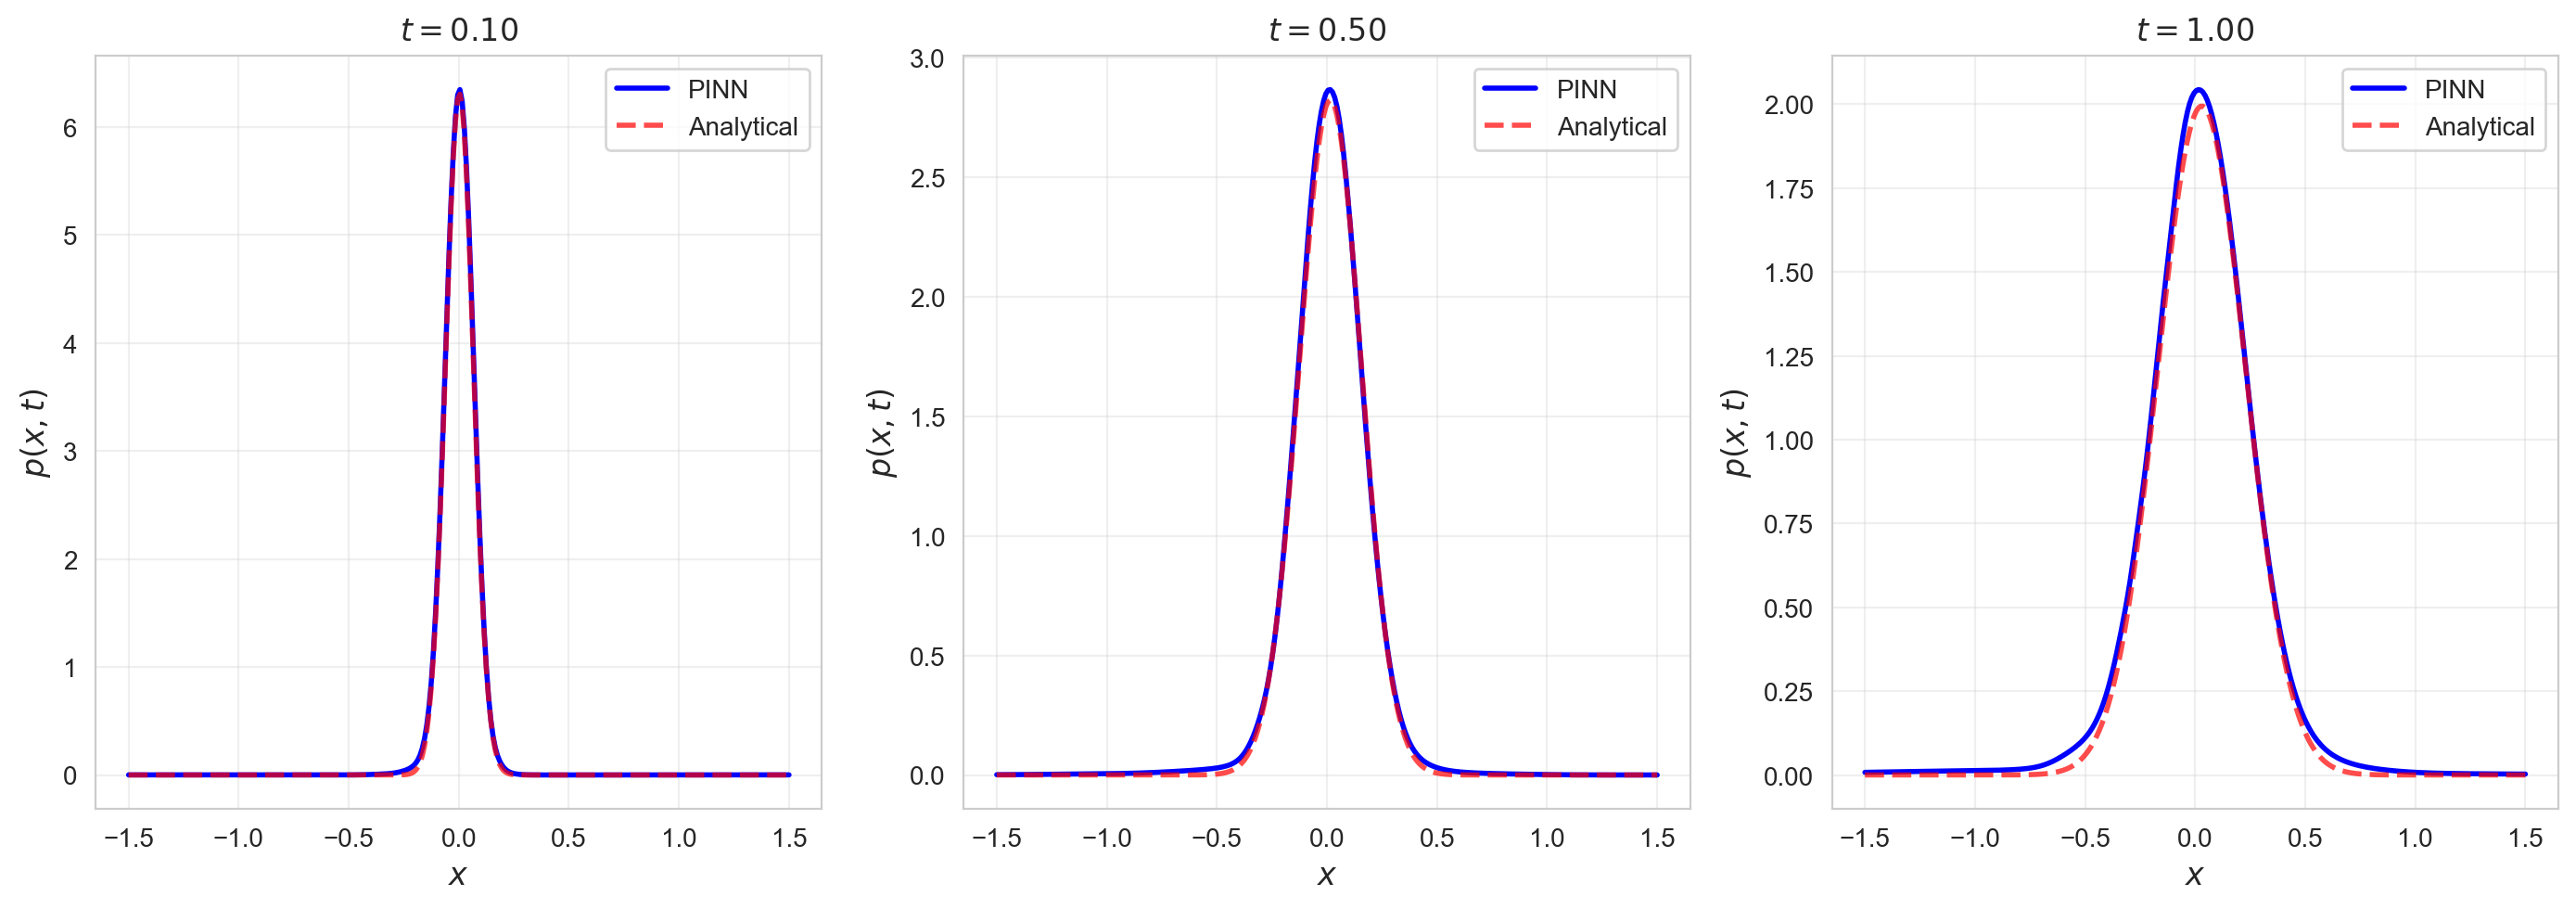

In [38]:
# Plot density evolution at multiple time points
fig = plot_density_evolution(
    network=solver.network,
    x_range=(-1.5, 1.5),
    time_points=[0.1, 0.5, 1.0],
    analytical_solution=equation.analytical_solution,
    num_points=300,
    device=device
)
plt.show()

## 3.2 Error Analysis


Error Metrics (vs. Analytical Solution):
  L2 Error: 1.227888e-02
  Max Absolute Error: 9.010315e-02
  Mean Absolute Error: 4.891771e-03


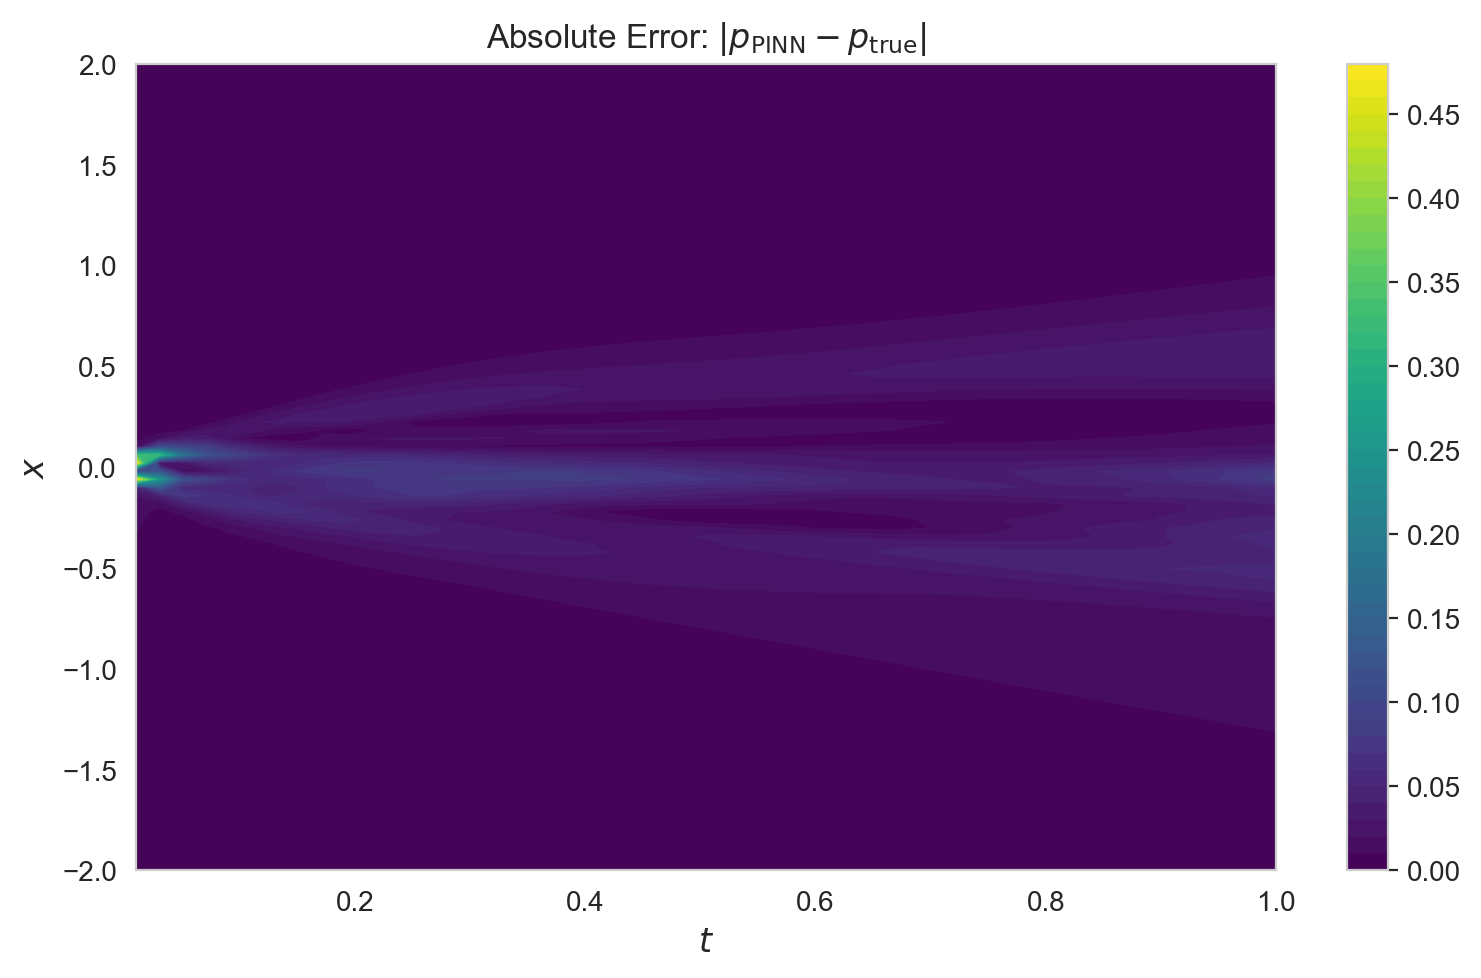

In [39]:
# Evaluate error metrics
errors = solver.evaluate_error(num_test_points=1000)

print("\nError Metrics (vs. Analytical Solution):")
print(f"  L2 Error: {errors['l2_error']:.6e}")
print(f"  Max Absolute Error: {errors['max_abs_error']:.6e}")
print(f"  Mean Absolute Error: {errors['mean_abs_error']:.6e}")

# Plot error heatmap
fig = plot_error_analysis(
    network=solver.network,
    analytical_solution=equation.analytical_solution,
    x_range=(-2.0, 2.0),
    t_range=(0.01, 1.0),
    device=device
)
plt.show()

# Part 4: Score Field Analysis

Extract and validate the score function for score-based generative modeling.

## 4.1 Extract Score Function

The **Stein score function** is:
$$s(x, t) = \nabla_x \log p(x, t) = \frac{\nabla_x p(x, t)}{p(x, t)}$$

The PINN approximates this using the trained density network $\mathcal{N}_\theta(x, t) \approx p(x, t)$:
$$s(x, t) \approx \frac{\nabla_x \mathcal{N}_\theta(x, t)}{\mathcal{N}_\theta(x, t)}$$

For the Gaussian analytical solution:
$$s(x, t) = -\frac{x - (x_0 + \alpha t)}{\sigma^2 t}$$

In [40]:
# Create score extractor
score_extractor = ScoreExtractor(
    network=solver.network,
    device=device,
    epsilon=1e-8
)

# Compute score at test points
x_test = torch.tensor([[-2.0], [0.0], [2.0]], device=device, dtype=torch.float32)
t_test = torch.tensor([[0.5], [0.5], [0.5]], device=device, dtype=torch.float32)

scores = score_extractor(x_test, t_test)

print("\nScore Function Evaluation at t=0.5:")
for i in range(len(x_test)):
    print(f"  s(x={x_test[i].item():.1f}, t=0.5) = {scores[i].item():.6f}")


Score Function Evaluation at t=0.5:
  s(x=-2.0, t=0.5) = 2.236508
  s(x=0.0, t=0.5) = 0.527298
  s(x=2.0, t=0.5) = -0.981121


## 4.2 Visualize Score Field 

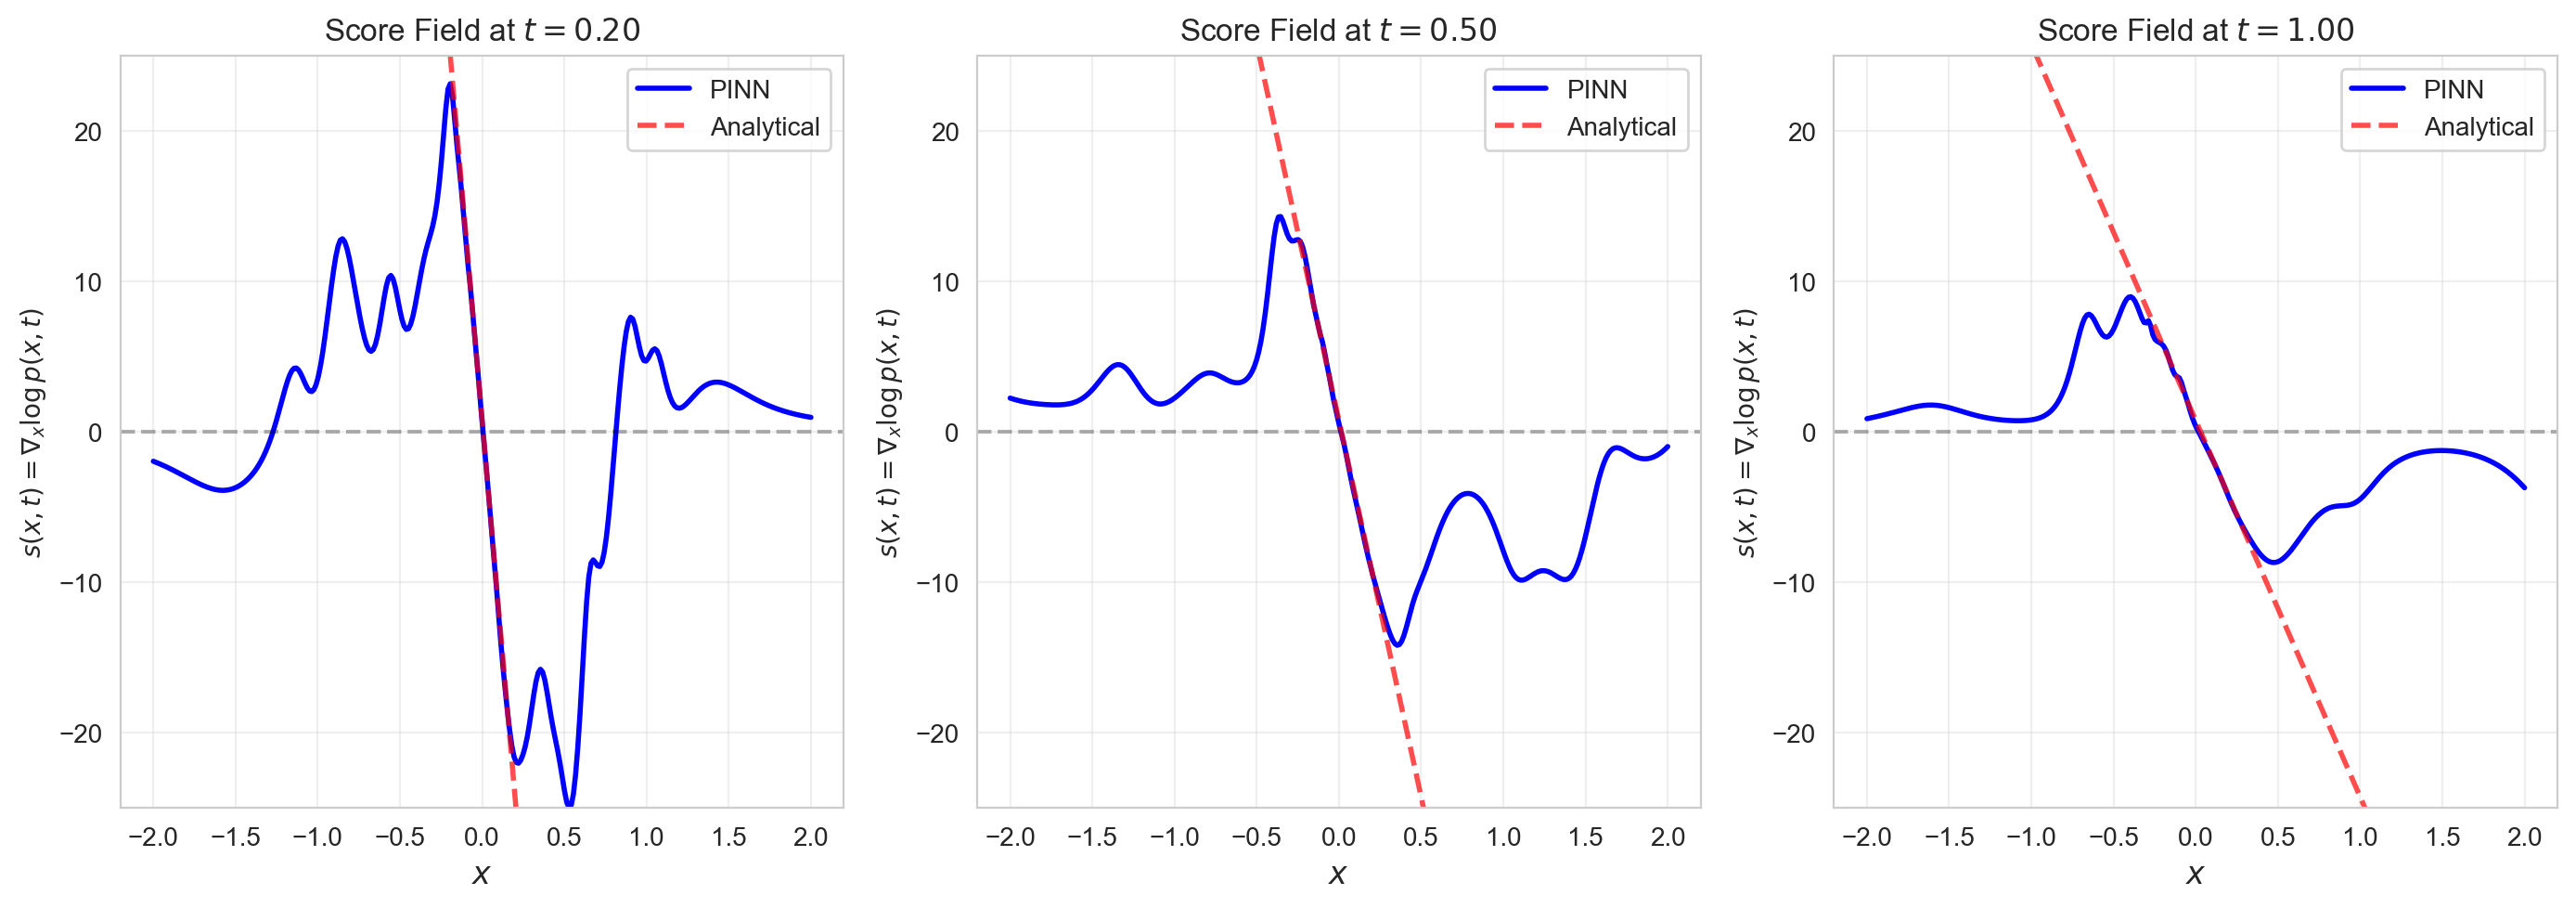

In [49]:
# Plot with analytical comparison
fig = plot_score_field(
    score_extractor=score_extractor,
    x_range=(-2.0, 2.0),
    y_range=(-25.0, 25.0),
    time_points=[0.2, 0.5, 1.0],
    num_points=300,
    device=device,
    analytical_score=equation.analytical_score  
)
plt.show()